In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
import re
from pymorphy2 import MorphAnalyzer
from spellchecker import SpellChecker
from autocorrect import Speller

In [3]:
df = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip')

In [4]:
df.head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


## L0. Формализация задачи и определение таргета

* **Формализация задачи:**  
Задача бинарной классификации  
  
* **Целевая переменная:**  
Таргет (столбец "label") - является ли отзыв фейковым. 1 - отзыв фейковый, 0 - отзыв настоящий  
  
* **Метрики:**
    1. Accuracy. Как будет показано далее в разделе, который посвящен EDA, имеет место серьезный дисбаланс классов, поэтому в данном случае метрику accuracy использовать не будем
    2. Precision и Recall. Если мы будем пытаться максимизировать только точность (Precision), не обращая внимание на полноту (Recall), то в ситуации, если мы получим высокую точность и низкую полноту, получится, что наша модель корректно относит отзывы к фейковым, но при этом мы выявляем далеко не все фейковые отзывы (из-за низкой полноты), что, скорее всего, с точки зрения бизнеса плохо. Рассмотрим теперь противоположную ситуацию: мы фокусируемся только на Recall и наша модель имеет высокую полноту и низкую точность, тогда получится, что модели удается выявить бОльшую часть фейковых отзывов, но при этом модель часть настоящих отзывов отнесла к фейковым, что опять же нехорошо с точки зрения бизнеса.
    3. F-мера. F-мера объединяет точность и полноту, поэтому в качестве основной метрики выберем её.

In [5]:
df.label.unique()

array([0, 1], dtype=int64)

In [6]:
real_sample = df[df.label == 0].text.head(7).to_list()
for i, s in enumerate(real_sample):
    print(i + 1, s)

1 Хотела купить на замену старых,по итогу эти  ужаснотупые ,не удобные ,рвут кутикулу ,а не режут.
2 Кабель подошёл, хорошо работает.
3 Визуально все хорошо. Не пробовали. Купили в подарок
4 Коробка в состоянии,, прошла Афган,,! Гладкая кожа носков сапог тоже уже не выглядит новой. Но сапоги вернула совсем не по этим причинам. Дело в том, что всамой модели сапог странное голенище. Дизайнер просчитался, решил вставить в эскиз замок, хотя стоило обойтись резинкой, дающей возможность вместить любую толщину икры женской ножки. Замок топорщит, держит странную форму, что портит вид сапог.
5 Джинсы хорошие качество отличное но дороговаты и Малы очень  брал на два размера больше но увы так что возврат
6 Камеры не закрывает, камеры в ровень с чехлом
7 Юлия не могли бы Вы проверить стеганку которую я вернула нет ли в карманах ключ от машин, я боюсь что в примерочной я по инерции их положила в карман и вернула позвони если есть по этому номеру 287896096


In [7]:
fake_sample = df[df.label == 1].text.head(7).to_list()
for i, s in enumerate(fake_sample):
    print(i + 1, s)

1 Запах по сравнению с обычным DOVE никакой. Оно не парфюмированное. Только баночки симпатичные и всё
2 Восторг! Очень приятный аромат, держится долго, очень удобный формат для сумочки.
3 Хорошее качество
4 Хорошо упакован, Оригенал 👌🏻спасибо
5 Оыоырыгыоцрцныоцн
6 Доставка-скорость света! Отличная ёмкость, кажется большеватой. НО! под любой стик мыла и пена остаётся внутри и не нужно собирать снаружи. Крышка садится не туго и не болтается. Транспортная упаковка надёжная. Всё без повреждений.
7 Здравствуйте! Товар получила, покупала подарок детям, нам очень понравилась. Соответствует как в картинки рисунки все аккуратно ни какого брака нет, фиксаторы даже запасом есть все отлично👍👍👍👍 спасибо большое за быструю сборку продавцу💐💐💐. И спасибо производителю💋💋💋


## L1. Первичный анализ данных (EDA)

### Посмотрим количество строк и общую информацию

In [9]:
print(f'Датафрейм содержит {df.shape[0]} строк и {df.shape[1]} колонок')

Датафрейм содержит 3123 строк и 13 колонок


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   text    3123 non-null   object 
 4   f1      3123 non-null   int64  
 5   f2      3123 non-null   int64  
 6   f3      3123 non-null   float64
 7   f4      3123 non-null   int64  
 8   f5      3123 non-null   int64  
 9   f6      3123 non-null   float64
 10  f7      3123 non-null   int64  
 11  f8      3123 non-null   int64  
 12  label   3123 non-null   int64  
dtypes: float64(2), int64(7), object(1), uint64(3)
memory usage: 317.3+ KB


### Обработка пропусков

In [11]:
df.isna().sum()

id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

Пропусков (в виде NaN'ов) в таблице нет, но стоит проверить, нет ли в столбце "text" пустых (или например, состоящих только из пробелов) строчек

In [12]:
df[(df.text.str.split().str.len() == 0)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label


Таких пустых строк нет, но есть другая особенность. Взглянем на текст отзыва с индексом 23 из датафрейма

In [13]:
df.loc[23].text

'︎ ︎ ︎ ︎ ︎ ︎'

In [14]:
ord(df.loc[23].text[0])

65038

Визуально кажется, что это строчка из пробелов, но на самом деле она состоит из пробелов, чередующихся с [каким-то непонятным символом unicode](https://symbl.cc/ru/search/?q=65038)

Также обнаружил строку только из нижних подчеркиваний.

In [15]:
df.loc[408].text

'__________'

Эти ситуации будем обрабатывать далее, когда будем выполнять препроцессинг строк

### Проанализируем баланс классов

In [16]:
balance = df.label.value_counts() 
print(f'Выборка содержит {balance.loc[0]} реальных и {balance.loc[1]} фейковых отзывов')

Выборка содержит 2298 реальных и 825 фейковых отзывов


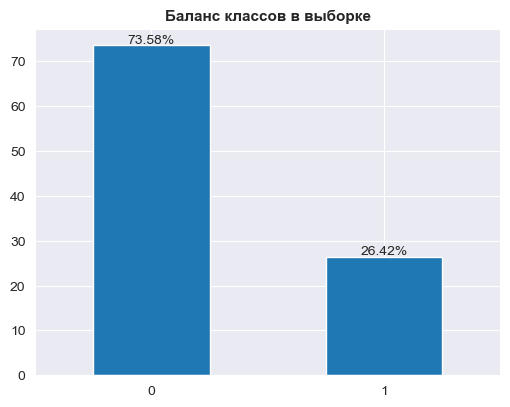

In [17]:
balance = balance * 100 / balance.sum()
ax = balance.plot(kind='bar', figsize=(6, 4.5))
plt.title('Баланс классов в выборке', fontsize=11, weight='bold')
plt.xticks(rotation=0)
for i in balance.index:
    plt.text(i, balance.loc[i] + 0.5, str(round(balance.loc[i], 2)) + '%', ha='center')
plt.show()

**Явный дисбаланс (в выборке преобладают реальные отзывы)**

### Подумаем, что означают прочие столбцы и проанализируем их

**Начнем со столбцов, которые содержат id**

In [18]:
id_cols = ['id1', 'id2', 'id3']
for col in id_cols:
    print(f'Уникальных значений в колонке {col} : {df[col].nunique()} / {len(df)}')

Уникальных значений в колонке id1 : 3049 / 3123
Уникальных значений в колонке id2 : 3006 / 3123
Уникальных значений в колонке id3 : 978 / 3123


переменная "id1" содержит id пользователя, "id2" - id товара?, "id3" содержит id продавца?  
Вывод сделан после просмотра глазами отзывов с одинаковыми айдишниками. Например, для id1 было местами заметно, что пишет один и тот же человек (некоторые отзывы с одинаковым id начинались одинаково), также кажется, что уникальных пользователей, скорее всего, должно быть больше, чем уникальных товаров и продавцов (см. ячейку выше).

**Перейдем к числовым фичам**

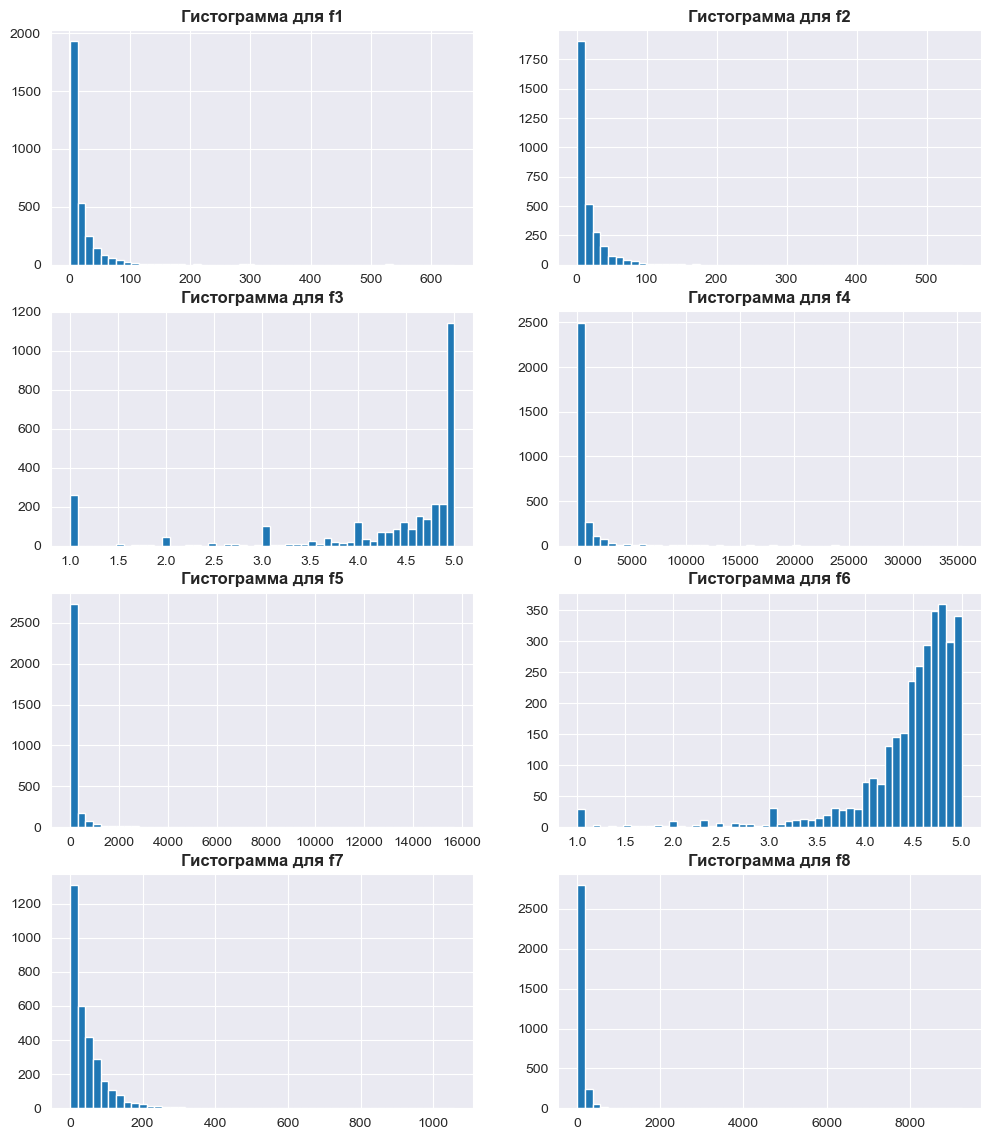

In [19]:
f_cols = ['f' + str(i) for i in range(1, 9)]
plt_arr = np.reshape(f_cols, (4, 2))

fig, axs = plt.subplots(4, 2, figsize=(12, 14))
for i in range(4):
    for j in range(2):
        cur_col = plt_arr[i][j]
        df[cur_col].hist(ax=axs[i][j], bins=50)
        axs[i][j].set_title(f'Гистограмма для {cur_col}', weight='bold')
plt.show()

По гистограммам видно, что для всех переменных, кроме f3 и f6 присутствуют существенные выбросы

Выдвинем предположение о том, что за информация хранится в числовых признаках f1-f8
* f3 - средняя оценка пользователя?
* f6 - средняя оценка товара/продавца?
* f1, f2, f4, f5, f7, f8 - int'ы, возможно, что-то из этого отражает общее количество отзывов у пользователя/товара/продавца  
  
Гипотеза 1: если id1 действительно содержит id пользователя, как я предположил выше, то, скорее всего, фичи f1, f2, f3, f7, f8 содержат какую-то информацию о пользователе, потому что для каждого отдельно взятого значения id1 значения этих признаков не меняются, проверить можно с помощью кода ниже.  
Гипотеза 2: если id2 действительно содержит id товара, как я предположил выше, то, скорее всего, переменная f6 это все-таки средняя оценка товара, а переменные f4, f5 это какие-то другие характеристики товаров (определил, используя аналогичную логику, что и для гипотезы 1, код приведен ниже)

In [ ]:
# df.id1.nunique() == df[['id1', 'f1', 'f2', 'f3', 'f7', 'f8']].drop_duplicates().shape[0]

In [36]:
# df[['id2', 'f4', 'f5', 'f6']][df['id2'].duplicated(keep=False)].drop_duplicates().shape[0] == df[df['id2'].duplicated(keep=False)].id2.nunique()

In [14]:
# def box_plt(df, col_name, ax):
#     sns.boxplot(x='label', y=col_name, data=df, ax=ax)
#     ax.set_title(f'Ящик с усами label-{col_name}', 
#                  fontsize=12, weight='bold')
    
# fig, axs = plt.subplots(4, 2, figsize=(10, 16))
# for i in range(4):
#     for j in range(2):
#         cur_col = plt_arr[i][j]
#         box_plt(df, cur_col, axs[i][j])
        
# fig.subplots_adjust(hspace=0.3)
# plt.show()

**Взглянем на описательные статистики**

In [20]:
df.loc[:, 'f1':].describe()

,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


**Корреляции**

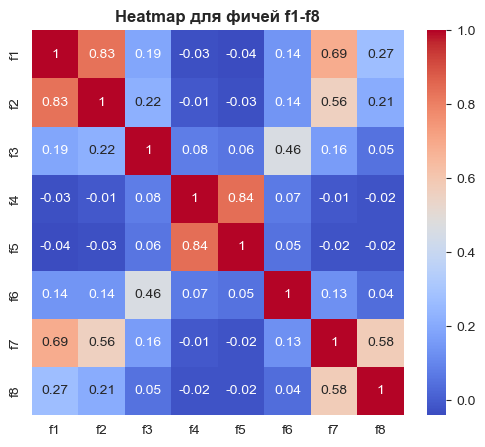

In [21]:
fig = plt.figure(figsize=(6, 5))
sns.heatmap(df[f_cols].corr().round(2), annot=True, cmap='coolwarm')
plt.title('Heatmap для фичей f1-f8', weight='bold')
plt.show()

Как видим, пары переменных f1-f2 и f4-f5 имеют достаточно сильную корреляцию

### Добавим и проанализируем новые признаки

In [22]:
def avg_word_len(s):
    return np.mean(list(map(len, word_tokenize(s, language='russian'))))

def avg_sent_len(s):
    return np.mean(list(map(len, sent_tokenize(s, language='russian'))))

def caps_portion(s, text_len):
    l = re.findall('[А-ЯA-Z]+', s)
    return sum(map(len, l)) / text_len    

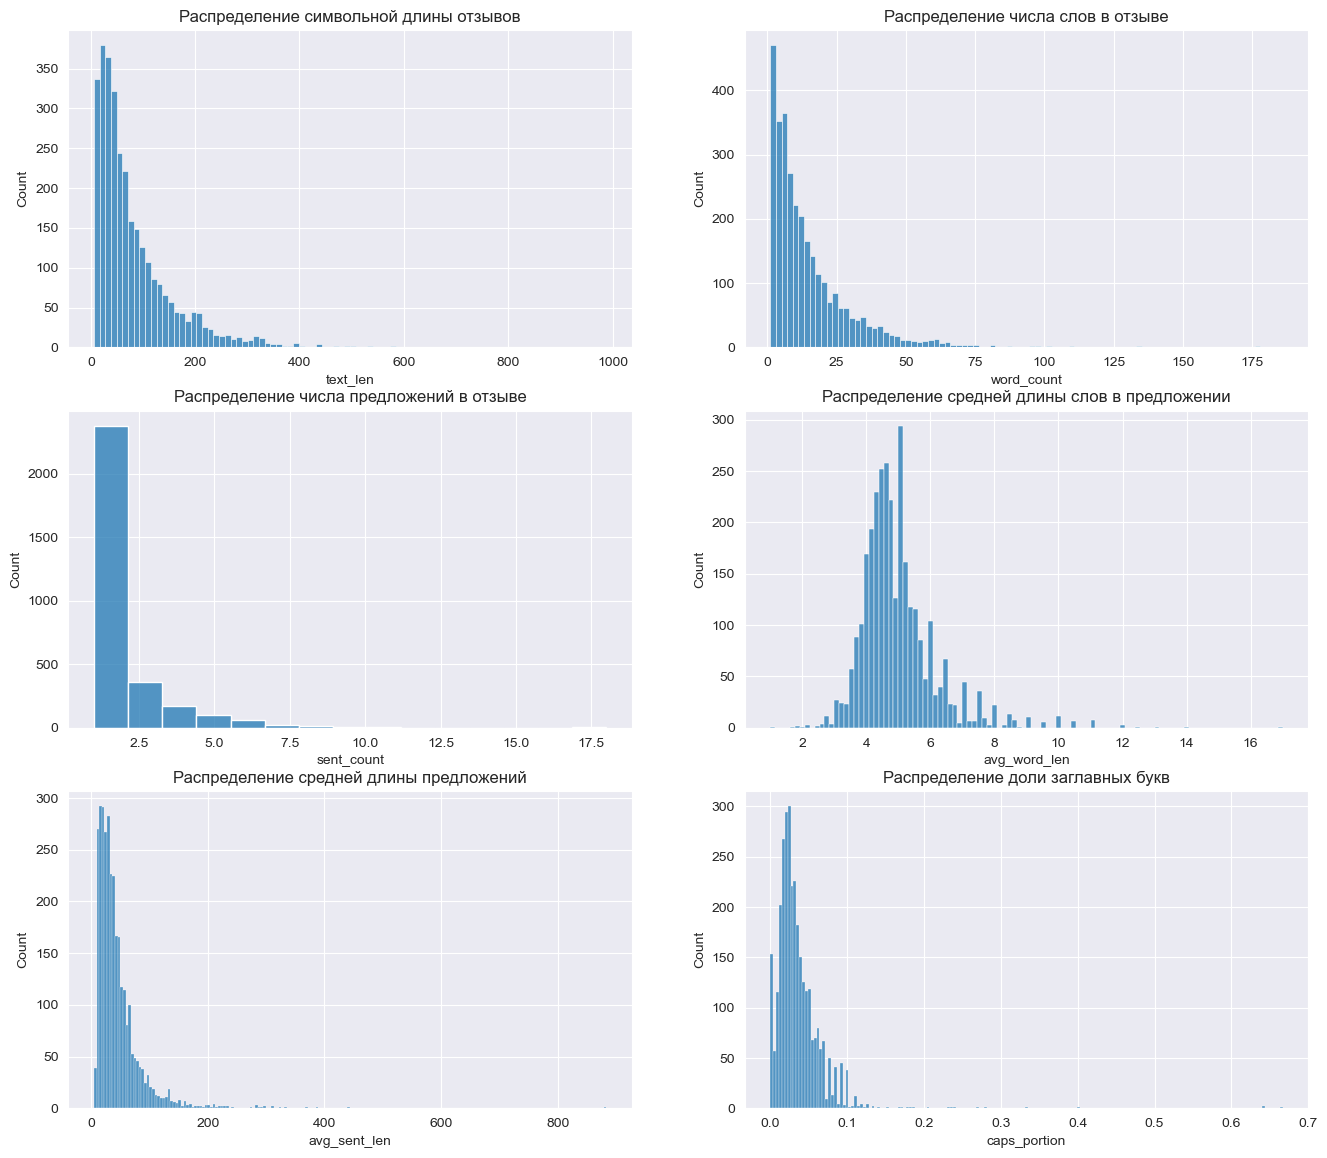

In [23]:
df['text_len'] = df.text.str.len()
df['word_count'] = df.text.apply(lambda x: len(word_tokenize(x, language='russian')))
df['sent_count'] = df.text.apply(lambda x: len(sent_tokenize(x, language='russian')))
df['avg_word_len'] = df.text.apply(avg_word_len)
df['avg_sent_len'] = df.text.apply(avg_sent_len)
df['caps_portion'] = df.apply(lambda x: caps_portion(x.text, x.text_len), axis=1) 

fig, ax = plt.subplots(3, 2, figsize=(16, 14))
sns.histplot(data=df.text_len, ax=ax[0][0])
ax[0][0].set_title('Распределение символьной длины отзывов')

sns.histplot(data=df.word_count, ax=ax[0][1])
ax[0][1].set_title('Распределение числа слов в отзыве')

sns.histplot(data=df.sent_count, ax=ax[1][0], bins=15)
ax[1][0].set_title('Распределение числа предложений в отзыве')

sns.histplot(data=df.avg_word_len, ax=ax[1][1])
ax[1][1].set_title('Распределение средней длины слов в предложении')

sns.histplot(data=df.avg_sent_len, ax=ax[2][0])
ax[2][0].set_title('Распределение средней длины предложений')

sns.histplot(data=df.caps_portion, ax=ax[2][1])
ax[2][1].set_title('Распределение доли заглавных букв')

plt.show()

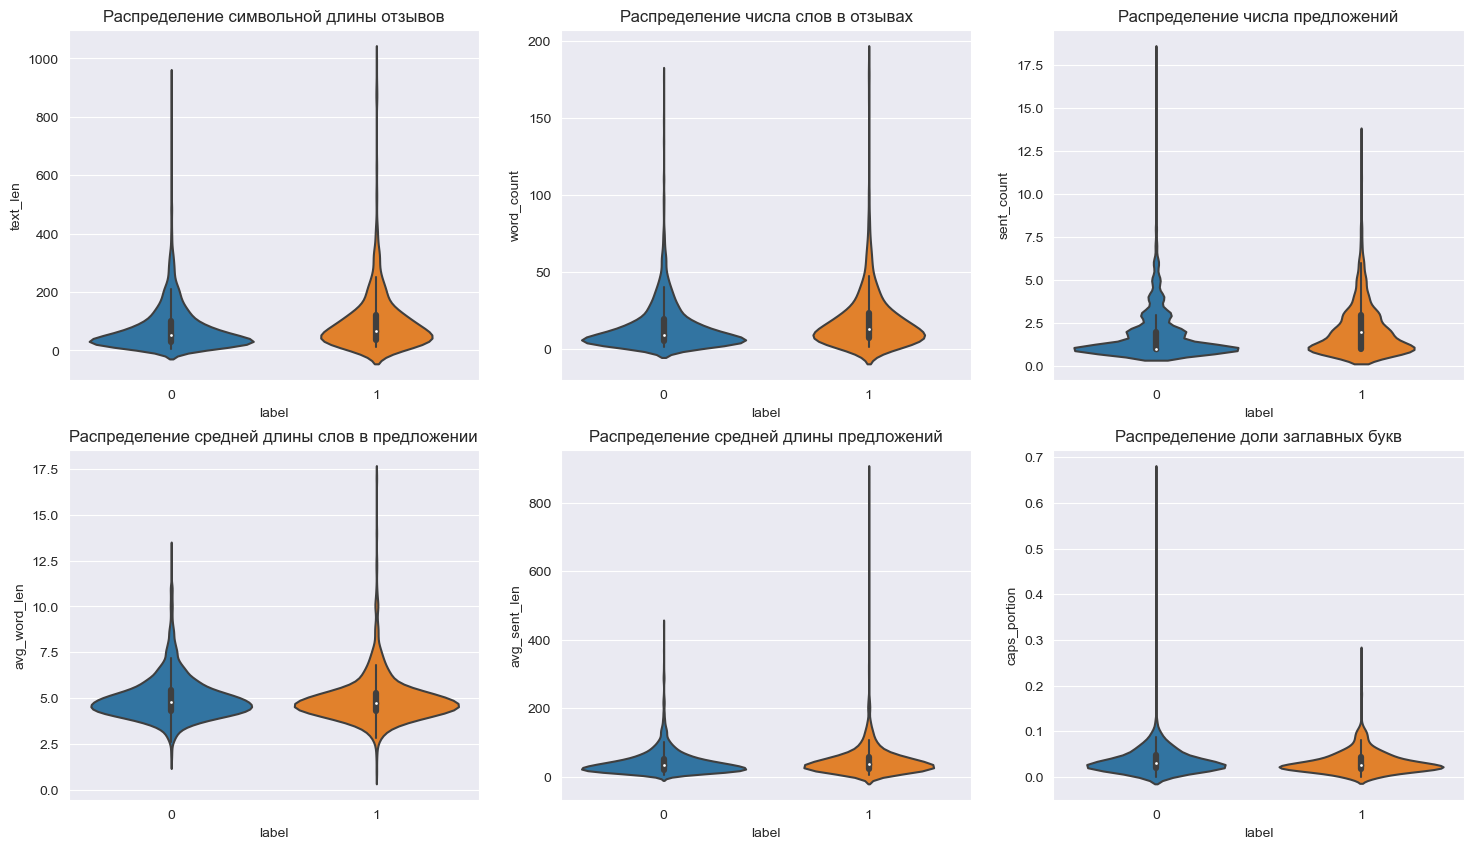

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))
sns.violinplot(data=df, x='label', y='text_len', ax=ax[0][0])
ax[0][0].set_title('Распределение символьной длины отзывов')

sns.violinplot(data=df, x='label', y='word_count', ax=ax[0][1])
ax[0][1].set_title('Распределение числа слов в отзывах')

sns.violinplot(data=df, x='label', y='sent_count', ax=ax[0][2], bins=15)
ax[0][2].set_title('Распределение числа предложений')

sns.violinplot(data=df, x='label', y='avg_word_len', ax=ax[1][0])
ax[1][0].set_title('Распределение средней длины слов в предложении')

sns.violinplot(data=df, x='label', y='avg_sent_len', ax=ax[1][1])
ax[1][1].set_title('Распределение средней длины предложений')

sns.violinplot(data=df, x='label', y='caps_portion', ax=ax[1][2])
ax[1][2].set_title('Распределение доли заглавных букв')

plt.show()

In [37]:
# fig, axs = plt.subplots(1, 2, figsize=(8, 3))
# box_plt(df, 'text_len', axs[0])
# box_plt(df, 'word_count', axs[1])
        
# fig.subplots_adjust(wspace=0.3)
# plt.show()

### Определим наличие дубликатов

In [25]:
df.text.describe()

count               3123
unique              3078
top       Отличный товар
freq                  11
Name: text, dtype: object

Тексты отзывов не являются уникальными

Небольшое замечание: заметил, что для самого частовстречаемого текста ("Отличный товар") в 2 случаях из 11 отзывы являются фейковыми, также видел несколько отзывов, которые состояли только из смайликов с большими пальцами, но они тоже имели разные метки, соответственно, можно сделать вывод, что текст отзыва, скорее всего, не является определяющим фактором того, вляется ли отзыв фейковым, поэтому нужно учитывать остальные фичи.

**Проверим, есть ли полные дубликаты (т.е. полное совпадение строк датафрейма)**

In [26]:
df[df.duplicated(keep=False)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion
45,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.80315,10,3,5.0,211,356,0,136,29,5,4.103448,26.4,0.036765
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.80315,10,3,5.0,211,356,0,136,29,5,4.103448,26.4,0.036765


Удалим вторую из двух совпадающих строчек

In [27]:
df = df.drop_duplicates()

Также есть два наблюдения, где один и тот же пользователь написал одинаковый текст для разных товаров одного продавца. Кажется, что удалять смысла не имеет.

In [28]:
df[df[['id1', 'text']].duplicated(keep=False)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion
2797,3884959853494955383,2378932839265966503,9034398454034589390,Внукам нравится!,44,31,4.909091,174,20,4.919540,44,73,0,16,3,1,5.0,16.0,0.0625
2831,3884959853494955383,12021259612890125721,9034398454034589390,Внукам нравится!,44,31,4.909091,490,55,4.804082,44,73,0,16,3,1,5.0,16.0,0.0625


Проверим, нет ли ситуации, когда один пользователь оставил более одного отзыва какому-то товару.

In [29]:
df[df[['id1', 'id2']].duplicated(keep=False)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion


### Обработка выбросов

Построим ящики с усами для числовых признаков, но исключим из рассмотрения фичи с оценками (f3 и f6), для них удаление выбросов производить не будем

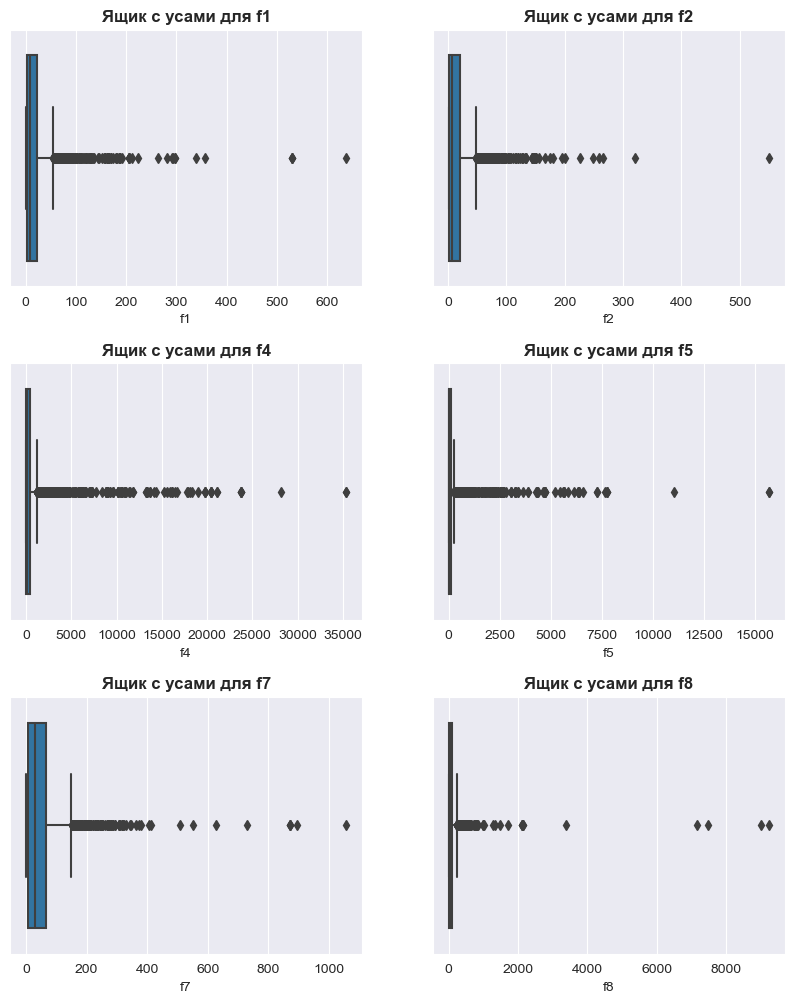

In [26]:
def box_plt(df, col_name, ax):
    sns.boxplot(x=col_name, data=df, ax=ax)
    ax.set_title(f'Ящик с усами для {col_name}', 
                 fontsize=12, weight='bold')
    
f_cols1 = ['f' + str(i) for i in range(1, 9) if i not in (3, 6)]
plt_arr = np.reshape(f_cols1, (3, 2))

fig, axs = plt.subplots(3, 2, figsize=(10, 12))
for i in range(3):
    for j in range(2):
        cur_col = plt_arr[i][j]
        box_plt(df, cur_col, axs[i][j])
        
fig.subplots_adjust(hspace=0.3)
plt.show()

In [40]:
df_copy = df.copy()

In [41]:
for col in f_cols1:
    print(col, ':')
    q1 = df_copy[col].quantile(0.25)
    q3 = df_copy[col].quantile(0.75)
    iqr = q3 - q1
    outliers = (df_copy[col] < (q1 - 1.5 * iqr)) | (df_copy[col] > (q3 + 1.5 * iqr))
    print(f'Нижний порог = {q1 - 1.5 * iqr}, верхний = {q3 + 1.5 * iqr}')
    print(f'Найдено {outliers.sum()} выбросов')
    print(f'Среди них {df_copy[outliers].label.sum()} фейковых')
    if input('Удалить выбросы? (y/n) ') == 'y':
        if input('Изменить пороги? (y/n) ') == 'y':
            # thres_low = int(input('Нижний порог: '))
            thres_up = int(input('Верхний порог: '))
            outliers = (df_copy[col] < thres_low) | (df_copy[col] > thres_up)
            print(f'Найдено {outliers.sum()} выбросов')
            print(f'Среди них {df_copy[outliers].label.sum()} фейковых')
            # df_copy = df_copy[(df_copy[col] >= thres_low) & (df_copy[col] <= thres_up)]
            if input('Удалить выбросы? (y/n) ') == 'y':
                df_copy = df_copy[~outliers]        
        else:
            df_copy = df_copy[~outliers]

f1 :
Нижний порог = -29.5, верхний = 54.5
Найдено 249 выбросов
Среди них 56 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f2 :
Нижний порог = -19.0, верхний = 37.0
Найдено 128 выбросов
Среди них 17 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f4 :
Нижний порог = -692.5, верхний = 1223.5
Найдено 373 выбросов
Среди них 126 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f5 :
Нижний порог = -76.0, верхний = 140.0
Найдено 259 выбросов
Среди них 81 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f7 :
Нижний порог = -60.0, верхний = 116.0
Найдено 100 выбросов
Среди них 22 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f8 :
Нижний порог = -87.0, верхний = 169.0
Найдено 78 выбросов
Среди них 33 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n


In [42]:
df_copy.shape[0]

1935

In [43]:
df_copy.label.mean()

0.2532299741602067

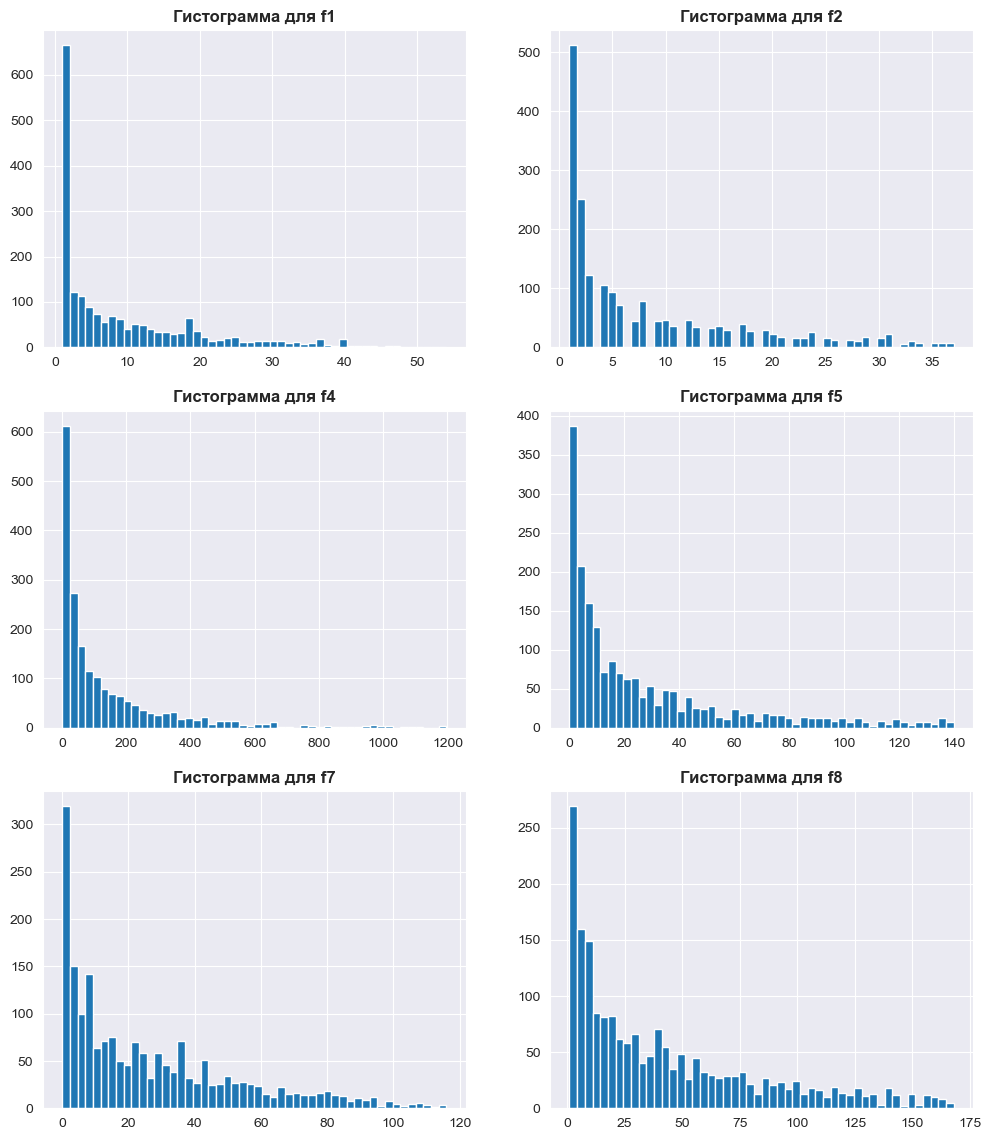

In [44]:
plt_arr = np.reshape(f_cols1, (3, 2))

fig, axs = plt.subplots(3, 2, figsize=(12, 14))
for i in range(3):
    for j in range(2):
        cur_col = plt_arr[i][j]
        df_copy[cur_col].hist(ax=axs[i][j], bins=50)
        axs[i][j].set_title(f'Гистограмма для {cur_col}', weight='bold')
plt.show()

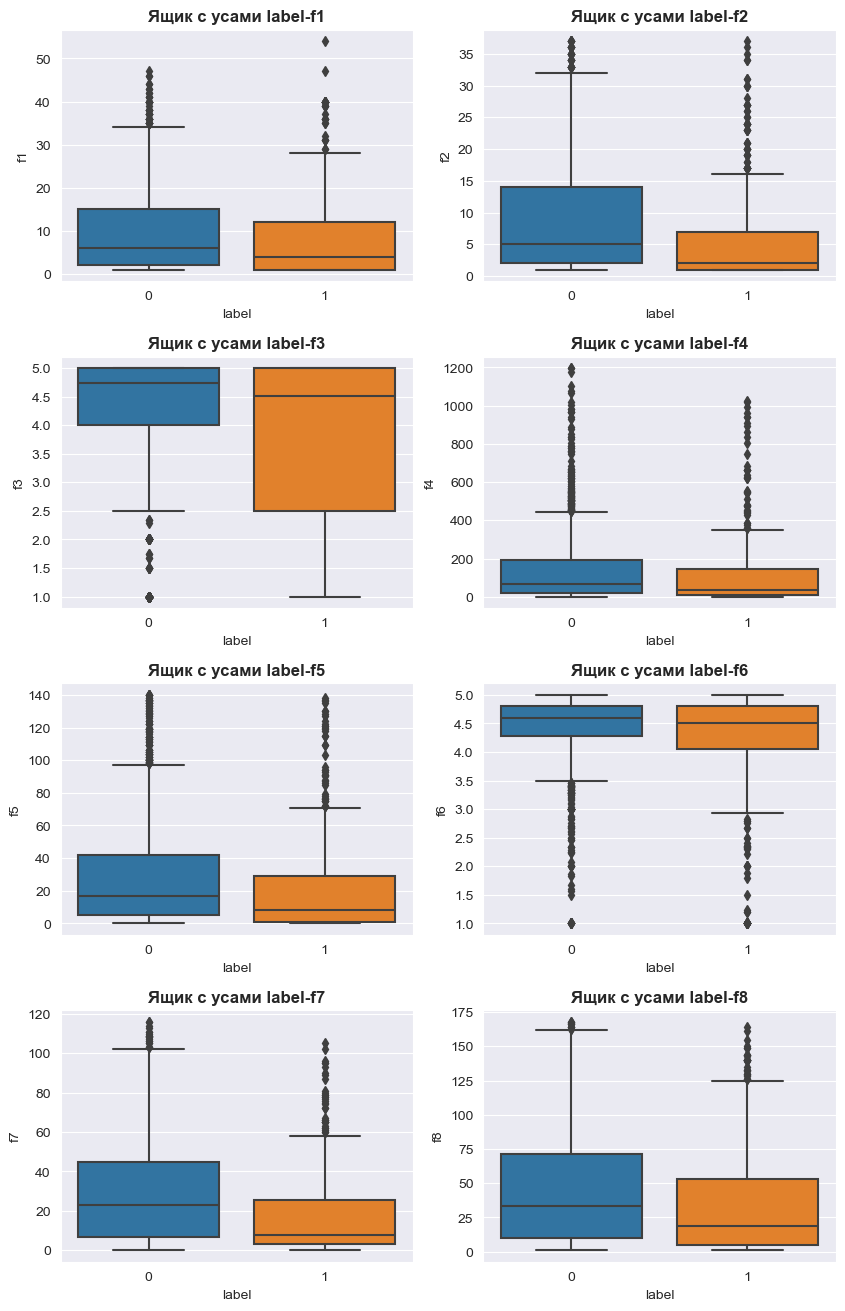

In [45]:
def box_plt(df, col_name, ax):
    sns.boxplot(x='label', y=col_name, data=df, ax=ax)
    ax.set_title(f'Ящик с усами label-{col_name}', 
                 fontsize=12, weight='bold')
    
fig, axs = plt.subplots(4, 2, figsize=(10, 16))
plt_arr = np.reshape(f_cols, (4, 2))
for i in range(4):
    for j in range(2):
        cur_col = plt_arr[i][j]
        box_plt(df_copy, cur_col, axs[i][j])
        
fig.subplots_adjust(hspace=0.3)
plt.show()

## Предобработка текстов

In [30]:
m = MorphAnalyzer()

In [31]:
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [32]:
# nltk.download('stopwords')  # скачаем стоп-слова для русского языка
print(stopwords.words('russian'))
stop = stopwords.words('russian') + list(punctuation)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [164]:
# spell = SpellChecker(language='ru')
# spell.correction('крута')
spell = Speller('ru', only_replacements=True)

In [174]:
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]

def correction_and_filter(s, stop_w):
    if s not in stop_w and len(s) > 2:
        corrected = spell.correction(s)
        if corrected is not None:
            if corrected not in stop_w and len(corrected) > 2:
                return corrected    
        

def preprocess_text(text, stop_w=stop, tokenizer=word_tokenize):  
    """функция предобработки текста"""
    # удаляем все, кроме букв кириллицы
    text = re.sub('[^А-Яа-я\s]', ' ', text)
    text = spell(text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    text = tokenizer(text.lower(), language='russian')
#     text = [correction_and_filter(w, stop_w) for w in text if correction_and_filter(w, stop_w) is not None] # list(map(correction, text))
    text = [w for w in text if (w not in stop_w) and (len(w) > 2)]
    text = lemmatize_text(text)
    return ' '.join(text)

In [175]:
tqdm.pandas()
df['clear_text'] = df.text.progress_apply(preprocess_text)

100%|██████████████████████████████████████████████████████████████████████████████| 3122/3122 [00:33<00:00, 93.92it/s]


In [176]:
df[['text', 'clear_text']].head(10)

,text,clear_text
0,"Хотела купить на замену старых,по итогу эти у...",хотеть купить замена старый итог ужаснотупой у...
1,Запах по сравнению с обычным DOVE никакой. Оно...,запах сравнение обычный никакой оно парфюмиров...
2,"Кабель подошёл, хорошо работает.",кабель подол работать
3,"Восторг! Очень приятный аромат, держится долго...",восторг очень приятный аромат держаться долго ...
4,Визуально все хорошо. Не пробовали. Купили в п...,визуально пробовать купить подарок
5,"Коробка в состоянии,, прошла Афган,,! Гладкая ...",коробка состояние пройти афган гладкий кожа но...
6,Джинсы хорошие качество отличное но дороговаты...,джинсы хороший качество отличный дороговатый м...
7,Хорошее качество,хороший качество
8,"Камеры не закрывает, камеры в ровень с чехлом",камера закрывать камера ровеня чехол
9,Юлия не могли бы Вы проверить стеганку которую...,юлия мочь проверить стёганка который вернуть к...


Есть небольшая проблема, состоящая в том, что для нескольких отзывов мы из-за такой очистки, по сути, совсем лишились текста отзыва. Также есть проблема, связанная с опечатками

In [38]:
df[(df.clear_text.str.split().str.len() == 0)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion,clear_text
23,14932418852539196783,11594206611029735520,5576082564072164535,︎ ︎ ︎ ︎ ︎ ︎,8,7,5.000000,96,27,4.520833,12,13,1,11,6,1,1.000000,11.0,0.000000,
369,8816573192000644470,5561072876759097566,7279234113731486608,Ок ок ок ок,7,7,4.428571,23,2,4.739130,124,236,0,11,4,1,2.000000,11.0,0.090909,
408,7228372016730991648,5850695483357674592,8160404367092487937,__________,2,2,2.500000,27,3,4.111111,3,6,1,10,1,1,10.000000,10.0,0.000000,
637,14533498944280804100,11860455876991826814,15053676552810216566,👍👍👍👍👍👍,13,13,4.846154,881,175,4.611805,84,127,0,6,1,1,6.000000,6.0,0.000000,
751,10749861286048421051,14949176600961148554,8223254633971568382,Все хорошо,29,27,4.862069,27,5,4.518519,75,87,0,10,2,1,4.500000,10.0,0.100000,
897,16003434369235304523,14926672264371803806,8223254633971568382,Всё хорошо.,18,18,4.777778,11,0,4.727273,21,30,0,11,3,1,3.333333,11.0,0.090909,
914,9158133609663457546,11023721191884698213,13057272459692676590,Хорошо но не тот,1,1,5.000000,198,68,4.156566,1,2,0,16,4,1,3.250000,16.0,0.062500,
1218,18020901957991569865,11775626371433002033,17776117386538683712,👌👍🏼👍🏼👍🏼👍🏼,6,6,5.000000,17,1,4.235294,9,14,0,9,1,1,9.000000,9.0,0.000000,
1298,15376744332096648284,6268099669634872571,6836784353719029392,Всё хорошо ...,4,4,5.000000,48,4,4.395833,4,6,0,14,3,1,4.000000,14.0,0.071429,
1374,7542702795411835022,9749876112909188500,7249931646404503757,Всё хорошо,16,16,4.750000,328,58,4.649390,29,79,0,10,2,1,4.500000,10.0,0.100000,


## Перейдем к обучению моделей

In [114]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# from sklearn.ensemble import RandomForestClassifier

In [195]:
# код для undersampling
# df['clear_text_len'] = df.clear_text.str.len()
# df_to_drop = df[df.label == 0].sort_values(by='clear_text_len')
# df_to_drop = df_to_drop.iloc[:df_to_drop.shape[0] // 10]
# df = df.drop(index=df_to_drop.index)

### Bag-of-words

In [86]:
vectorizer = CountVectorizer(preprocessor=preprocess_text, tokenizer=word_tokenize,
                             min_df=3, token_pattern='[А-Яа-я\s]+')
bow = vectorizer.fit_transform(df.clear_text)
bow

<3122x1464 sparse matrix of type '<class 'numpy.int64'>'
	with 20728 stored elements in Compressed Sparse Row format>

In [219]:
vectorizer = CountVectorizer(preprocessor=preprocess_text, tokenizer=word_tokenize,
                             min_df=3, token_pattern='[А-Яа-я\s]+')
bow = vectorizer.fit_transform(df.clear_text)
bow

<3122x1480 sparse matrix of type '<class 'numpy.int64'>'
	with 20857 stored elements in Compressed Sparse Row format>

In [220]:
bow_df = pd.DataFrame(bow.toarray(), columns=vectorizer.get_feature_names_out(),
                      index=df.index)
# bow_df.head(3)

In [221]:
df1 = pd.concat([df, bow_df], axis=1)

In [222]:
X, y = df1.drop(columns='label'), df1.label

In [223]:
X = X.drop(columns=['id1', 'id2', 'id3', 'text', 'clear_text'])

### L3. Разбиение на train, val, test

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                random_state=42, stratify=y_test)
print(len(y_train), 'объектов в обучающей выборке')
print(len(y_val), 'объектов в валидационной выборке')
print(len(y_test), 'объектов в тестовой выборке')

2497 объектов в обучающей выборке
312 объектов в валидационной выборке
313 объектов в тестовой выборке


In [225]:
numeric = list(X.loc[:, :'caps_portion'].columns)
print(numeric)

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'text_len', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len', 'caps_portion']


In [226]:
column_transformer = ColumnTransformer([
    ('scaler', StandardScaler(), numeric)  
], remainder='passthrough')

X_train_transf = column_transformer.fit_transform(X_train)
X_val_transf = column_transformer.transform(X_val)
X_test_transf = column_transformer.transform(X_test)

In [189]:
def print_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    '''
    Удобная функция для вывода метрик.
    '''
    train_dct, val_dct, test_dct = {}, {}, {}
    dct_lst = [train_dct, val_dct, test_dct]
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score
    }
    for m in metrics:
        for i, cur_set in enumerate(zip([y_train, y_val, y_test], 
                                     [pred_train, pred_val, pred_test])):
            dct_lst[i][m] = metrics[m](*cur_set)
            
    res_df = pd.DataFrame({'train': train_dct, 'val': val_dct, 'test': test_dct}).T
    res_df['roc_auc'] = [
        roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        roc_auc_score(y_val, model.predict_proba(X_val)[:, 1]),
        roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
    ]
    display(res_df.round(3))

In [227]:
lr = LogisticRegression(max_iter=5000, random_state=42, # solver='liblinear',
                        C=0.15, class_weight='balanced', penalty='l2')

In [228]:
lr.fit(X_train_transf, y_train)

LogisticRegression(C=0.15, class_weight='balanced', max_iter=5000,
                   random_state=42)

In [113]:
print_metrics(lr, X_train_transf, y_train, 
              X_val_transf, y_val, X_test_transf, y_test)

,accuracy,precision,recall,f1,roc_auc
train,0.811,0.625,0.714,0.667,0.864
val,0.689,0.416,0.451,0.433,0.653
test,0.703,0.449,0.530,0.486,0.704


In [192]:
print_metrics(lr, X_train_transf, y_train, 
              X_val_transf, y_val, X_test_transf, y_test)

,accuracy,precision,recall,f1,roc_auc
train,0.811,0.624,0.715,0.667,0.866
val,0.689,0.416,0.451,0.433,0.653
test,0.712,0.464,0.542,0.500,0.701


### Теперь используем TF-IDF для векторизации текстов

In [40]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_text, tokenizer=word_tokenize,
                             min_df=3, token_pattern='[А-Яа-я\s]+')
tf_idf = vectorizer.fit_transform(df.clear_text)
tf_idf

<3122x1464 sparse matrix of type '<class 'numpy.float64'>'
	with 20728 stored elements in Compressed Sparse Row format>

In [55]:
tf_idf_df = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names_out(),
                         index=df.index)
# tf_idf_df.loc[1][tf_idf_df.loc[1] > 0]
tf_idf_df.head(3)

,абсолютно,адаптер,айфон,аккуратно,аккуратный,активный,аллергия,альбом,аппарат,аппетит,...,эксплуатация,электризоваться,этикетка,это,эффект,юбка,явно,январь,яркий,ящик
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
df1 = pd.concat([df, tf_idf_df], axis=1)

In [133]:
X, y = df1.drop(columns='label'), df1.label

In [134]:
X = X.drop(columns=['id1', 'id2', 'id3', 'text', 'clear_text'])

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, 
                                                random_state=42, stratify=y_test)
print(len(y_train), 'объектов в обучающей выборке')
print(len(y_val), 'объектов в валидационной выборке')
print(len(y_test), 'объектов в тестовой выборке')

2497 объектов в обучающей выборке
312 объектов в валидационной выборке
313 объектов в тестовой выборке


In [136]:
X_train.iloc[:5, :20]

,f1,f2,f3,f4,f5,f6,f7,f8,text_len,word_count,sent_count,avg_word_len,avg_sent_len,caps_portion,абсолютно,адаптер,айфон,аккуратно,аккуратный,активный
399,3,3,5.000000,14,3,5.000000,7,12,25,4,1,5.500000,25.000000,0.040000,0.0,0.0,0.0,0.0,0.0,0.0
1244,3,3,4.666667,9,7,4.000000,3,6,491,89,4,4.651685,122.000000,0.032587,0.0,0.0,0.0,0.0,0.0,0.0
368,1,1,5.000000,10192,5663,4.551413,7,17,48,9,3,4.666667,15.333333,0.062500,0.0,0.0,0.0,0.0,0.0,0.0
118,3,3,5.000000,2,1,5.000000,22,23,46,7,1,5.857143,46.000000,0.021739,0.0,0.0,0.0,0.0,0.0,0.0
1002,2,2,5.000000,14,0,4.214286,1,6,155,27,2,5.000000,77.000000,0.032258,0.0,0.0,0.0,0.0,0.0,0.0


In [137]:
# column_transformer = ColumnTransformer([
#     ('scaler', StandardScaler(), numeric)  
# ], remainder='passthrough')

X_train_transf = column_transformer.fit_transform(X_train)
X_val_transf = column_transformer.transform(X_val)
X_test_transf = column_transformer.transform(X_test)

In [83]:
lr = LogisticRegression(max_iter=5000, random_state=42, # solver='liblinear',
                        C=0.5, class_weight='balanced', penalty='l2')

In [84]:
lr.fit(X_train_transf, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=5000,
                   random_state=42)

In [85]:
print_metrics(lr, X_train_transf, y_train, 
              X_val_transf, y_val, X_test_transf, y_test)

,accuracy,precision,recall,f1,roc_auc
train,0.789,0.581,0.726,0.645,0.846
val,0.721,0.472,0.512,0.491,0.719
test,0.681,0.425,0.578,0.490,0.721


In [ ]:
# lgbm_clf = LGBMClassifier(max_depth=4, learning_rate=0.002, 
#                       n_estimators=20000, random_state=42)
# lgbm_clf.fit(X_train_transf, y_train)